# Characterizing Clinical Text Using Clinical LLM Latent Representations

## Overview
This notebook serves as an interface for corpus embeddings of MIMIC-IV discharge reports.
331,793 unique discharge reports exist in MIMIC-IV and 12 LLMs are being explored.
The notebooks provides code for loading the corpus embeddings generated on NERSC's Perlmutter super-computer.
Additionally, there is code for rendering the 2D UMAP projections with KMeans derived cluster assignments.
Lastly, clinical text can be rendered in the notebook as well.

## Purpose of Research
There is increased interest in employing LLMs for clinical NLP. The current trend in the
field is towards scaling LLM development to larger model sizes and pretraining corpuses.
Even so, there are lack of tools for assessing the quality of LLM latent representations
in capturing important clinical variables. We will explore latent representations of 
different contemporary LLMs to identify model configurations which better characterize
phenotype cohorts and common measures of clinical outcomes.



In [1]:
#- Imports
import os, torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from IPython.display import Markdown


## Load LLM Latent Space Model

The following latent space models are available.

```
$ tree -L 3 -I "ids|toks|embeds" output/embeds/

output/embeds/
├── BioBART_base.discharge.layer.0
│   ├── kmeans
│   │   ├── nclusters.128.pt
│   │   ├── nclusters.256.pt
│   │   ├── nclusters.32.pt
│   │   └── nclusters.64.pt
│   └── umap
│       ├── nclusters.128.nn.256.min.0.001.csv
│       ├── nclusters.128.nn.256.min.0.01.csv
│       ├── nclusters.128.nn.256.min.0.1.csv
│       ├── nclusters.256.nn.256.min.0.001.csv
│       ├── nclusters.256.nn.256.min.0.01.csv
│       ├── nclusters.256.nn.256.min.0.1.csv
│       ├── nclusters.32.nn.256.min.0.001.csv
│       ├── nclusters.32.nn.256.min.0.01.csv
│       ├── nclusters.32.nn.256.min.0.1.csv
│       ├── nclusters.64.nn.256.min.0.001.csv
│       ├── nclusters.64.nn.256.min.0.01.csv
│       └── nclusters.64.nn.256.min.0.1.csv
├── BioBERT_base.discharge.layer.0
│   ├── kmeans
│   │   ├── nclusters.128.pt
│   │   ├── nclusters.256.pt
│   │   ├── nclusters.32.pt
│   │   └── nclusters.64.pt
│   └── umap
│       ├── nclusters.128.nn.256.min.0.001.csv
│       ├── nclusters.128.nn.256.min.0.01.csv
│       ├── nclusters.128.nn.256.min.0.1.csv
│       ├── nclusters.256.nn.256.min.0.001.csv
│       ├── nclusters.256.nn.256.min.0.01.csv
│       ├── nclusters.256.nn.256.min.0.1.csv
│       ├── nclusters.32.nn.256.min.0.001.csv
│       ├── nclusters.32.nn.256.min.0.01.csv
│       ├── nclusters.32.nn.256.min.0.1.csv
│       ├── nclusters.64.nn.256.min.0.001.csv
│       ├── nclusters.64.nn.256.min.0.01.csv
│       └── nclusters.64.nn.256.min.0.1.csv
├── BioGPT_base.discharge.layer.0
│   └── kmeans
│       ├── nclusters.128.pt
│       ├── nclusters.256.pt
│       ├── nclusters.32.pt
│       └── nclusters.64.pt
└── BioMegatron_base.discharge.layer.0
    └── kmeans
        ├── nclusters.128.pt
        ├── nclusters.256.pt
        ├── nclusters.32.pt
        └── nclusters.64.pt

10 directories, 40 files

```


In [2]:
#- Latent Space Parameters
model = "BioBERT_base"
layer = 0 # idx from penultimate layer back
nb_neighbors = 256
min_dist = 0.001
nb_clusters = 256

#-
MIMIC4REPORTS = "/global/cfs/cdirs/m1532/Projects_MVP/_datasets/MIMIC_IV/physionet.org/files/mimic-iv-note/2.2/note/discharge.csv"
EMBEDPATH = "/pscratch/sd/r/rzamora/OSA_Phenotyping_LLMs/output/embeds/{}.discharge.layer.{}/".format(model, layer)
UMAPPATH = "{}umap/nclusters.{}.nn.{}.min.{}.csv".format(EMBEDPATH, nb_clusters, nb_neighbors, min_dist)
KMEANSPATH = "{}kmeans/nclusters.{}.pt".format(EMBEDPATH, nb_clusters)

In [3]:
#- Load Discharge Reports
reports = pd.read_csv(MIMIC4REPORTS)

#- Load UMAP Results
umap = pd.read_csv(UMAPPATH)
umap = umap.rename(columns={"id":"note_id"}).sort_values("sha224").reset_index(drop=True)

#- Load Kmeans Results
kmeans = torch.load(KMEANSPATH)
kmeans = kmeans / kmeans.max()
clusters = kmeans.argmin(1)
probs = [kmeans[i,clusters[i]].item() for i in range(len(clusters))]

umap["cluster"] = clusters.numpy()
umap["probs"] = probs

#- Merge
df = reports[["subject_id", "hadm_id", "note_id", "storetime", "text"]].merge(umap, on="note_id", how="left")
dfs = []
for nme, grp in df.groupby("cluster"):
    grp = grp.sort_values("probs").reset_index(drop=True)
    grp["probs"] = [(i/len(grp)) for i in range(len(grp))]
    dfs.append(grp)
df = pd.concat(dfs).reset_index(drop=True)

## Index Nearest-Neighbors To Cluster Centroids

In [4]:
#-
cluster = 18

#- 
color_palette = sns.color_palette("Spectral", df.cluster.max()+1)

#-
match = (df.cluster == cluster)
df["score"] = (match * (1-df.probs))
df["size"] = (match * 0.999) + 0.001
df["color"] = color = df[["cluster", "score"]].apply(lambda x: sns.desaturate(color_palette[int(x.cluster)], x.score), axis=1)
df["alpha"] = (match*0.5) + 0.5
df = df.sort_values("score", ascending=False)
df

,subject_id,hadm_id,note_id,storetime,text,sha224,umap_1,umap_2,cluster,probs,score,size,color,alpha
27361,17802132,28599766,17802132-DS-18,2171-04-04 08:02:00,\nName: ___ Unit No: ___\...,f8501974b433ce227badf6e05b7b365e6623bdf1e7a7e6...,1.388188,4.491976,18,0.000000,1.000000,1.000,"(0.7718569780853518, 0.17277970011534027, 0.29...",1.0
27362,12263281,26435964,12263281-DS-4,2172-07-28 12:55:00,\nName: ___ Unit No: ___...,8defc48a3ad0550fd857609db362b464aea902ed24884a...,2.544665,4.885179,18,0.001163,0.998837,1.000,"(0.771508677342346, 0.17312800085834612, 0.295...",1.0
27363,12393160,21986994,12393160-DS-4,2180-06-07 19:21:00,\nName: ___ Unit No: ___\...,cfd37082f01963f8e2cf8b5300178a52cebb72427fe29e...,0.843221,4.381842,18,0.002326,0.997674,1.000,"(0.7711603765993402, 0.17347630160135186, 0.29...",1.0
27364,17006412,26571634,17006412-DS-19,2182-07-04 16:50:00,\nName: ___ Unit No: ...,b521ac03462b3b58ea53075f461eb58eb82243548228fb...,2.349578,6.203313,18,0.003488,0.996512,1.000,"(0.7708120758563344, 0.1738246023443577, 0.295...",1.0
27365,13646527,20071109,13646527-DS-10,2112-09-22 09:57:00,\nName: ___ Unit No: ___\...,18a24fe1e4a89503acda4934f031656391e3e066aa1c1b...,2.150409,5.132771,18,0.004651,0.995349,1.000,"(0.7704637751133285, 0.17417290308736355, 0.29...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111170,18886299,21283303,18886299-DS-11,2119-02-27 23:00:00,\nName: ___ Unit No: ___...,9636b6f604209261869350d0110c806598cde55c15fe51...,3.856494,5.524227,82,0.271540,0.000000,0.001,"(0.7044598231449442, 0.7044598231449442, 0.704...",0.5
111169,17672799,23333045,17672799-DS-14,2129-07-12 13:35:00,\nName: ___ Unit No: ___\n...,99a6ba955da1f818c0f8b8607fadd8179e3e1d5af80274...,2.259902,3.863212,82,0.270888,0.000000,0.001,"(0.7044598231449442, 0.7044598231449442, 0.704...",0.5
111168,10944771,27644582,10944771-DS-11,2163-05-29 21:23:00,\nName: ___ Unit No: ___\n ...,0f378f91e2fc9ab136d99b91d0547cb409f25ac83ccca5...,4.929780,7.498880,82,0.270235,0.000000,0.001,"(0.7044598231449442, 0.7044598231449442, 0.704...",0.5
111167,11778517,23519513,11778517-DS-10,2171-05-26 17:46:00,\nName: ___ Unit No: ___\n...,1915151d3c9010e1ec35d76f51e9ab1604f2c0dbd35695...,2.295781,3.068261,82,0.269582,0.000000,0.001,"(0.7044598231449442, 0.7044598231449442, 0.704...",0.5


<AxesSubplot: xlabel='umap_1', ylabel='umap_2'>

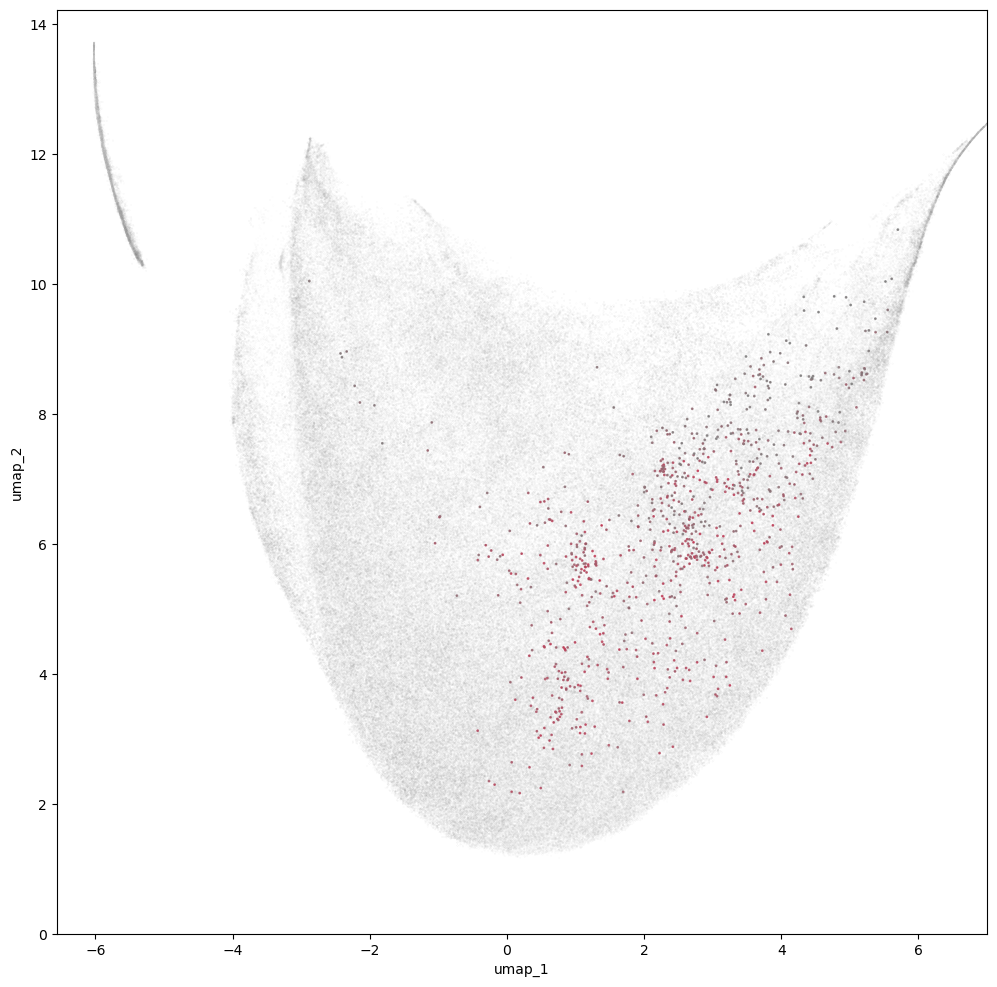

In [5]:
#- Render Scatter Plot
plot_args = {"x": "umap_1",
             "y": "umap_2",
             "c": "color",
             "alpha": 0.8,
             "s": "size"}
plt.rcParams['figure.figsize'] = [12, 12]
ax = df.plot.scatter(**plot_args)
minax = min(df.umap_1.min(), df.umap_2.min()) - 0.5
maxax = max(df.umap_1.max(), df.umap_2.max()) + 0.5
ax.set_xlim(minax,7)
ax.set_ylim(0,maxax)
ax

## Rendering Clinical Text

In [ ]:
#- 
NOTEIDX = 0
print(df.iloc[NOTEIDX])
display(Markdown(df.iloc[NOTEIDX].text))

In [ ]:
#- 
NOTEIDX = 7
print(df.iloc[NOTEIDX])
display(Markdown(df.iloc[NOTEIDX].text))